# H2 — Comparaison des 4 datasets : av-1, av-2, rw-1, rw-2

## Contenu

1. **Entre les 4 datasets — Stage I** : violin des corrélations (NREM I + REM I poolés) pour chaque dataset côte à côte
2. **Entre les 4 datasets — Stage II** : même chose pour NREM II + REM II
3. **Stage I vs Stage II par dataset** : pour chaque dataset, comparaison de la distribution Stage I vs Stage II
4. **KDE par dataset** : distribution complète des corrélations par dataset et par stage
5. **Tests statistiques** : Kruskal-Wallis global + Mann-Whitney U pairwise entre les 4 datasets

## Codes couleur
- `av-1` : rouge foncé
- `av-2` : rouge clair
- `rw-1` : bleu foncé
- `rw-2` : bleu clair

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

In [2]:
# --- Chargement des 4 datasets ---
DATASETS_RAW = {
    'av-1': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-av-1.pkl'),
    'av-2': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-av-2.pkl'),
    'rw-1': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-rw-1.pkl'),
    'rw-2': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-rw-2.pkl'),
}

STAGE_I_LABELS  = {'NREM I',  'REM I'}
STAGE_II_LABELS = {'NREM II', 'REM II'}

# DATASETS[(name, 'Stage I')] et DATASETS[(name, 'Stage II')]
DATASETS = {}
for name, df in DATASETS_RAW.items():
    DATASETS[(name, 'Stage I')]  = df[df['epoch_label'].isin(STAGE_I_LABELS)].reset_index(drop=True)
    DATASETS[(name, 'Stage II')] = df[df['epoch_label'].isin(STAGE_II_LABELS)].reset_index(drop=True)

# Couleurs et styles
COLORS = {
    'av-1': '#922b21',  # rouge foncé
    'av-2': '#e74c3c',  # rouge clair
    'rw-1': '#1a5276',  # bleu foncé
    'rw-2': '#3498db',  # bleu clair
}
FACE_COLORS = {
    'av-1': '#f1948a',
    'av-2': '#fadbd8',
    'rw-1': '#7fb3d3',
    'rw-2': '#d6eaf8',
}
DATASET_NAMES = list(DATASETS_RAW.keys())
STAGES = ['Stage I', 'Stage II']

# Résumé
print(f"{'Dataset':<8} {'Stage':<10} {'n epochs':>9}  Labels")
print('-' * 55)
for name in DATASET_NAMES:
    for stage in STAGES:
        df = DATASETS[(name, stage)]
        counts = df['epoch_label'].value_counts().to_dict()
        d = df['t_end'] - df['t_start']
        print(f"{name:<8} {stage:<10} {len(df):>9}  {counts}  "
              f"(mean={d.mean():.1f}s)")

Dataset  Stage       n epochs  Labels
-------------------------------------------------------
av-1     Stage I          525  {'NREM I': 268, 'REM I': 257}  (mean=15.6s)
av-1     Stage II         490  {'NREM II': 248, 'REM II': 242}  (mean=13.5s)
av-2     Stage I           52  {'NREM I': 32, 'REM I': 20}  (mean=77.0s)
av-2     Stage II          43  {'NREM II': 26, 'REM II': 17}  (mean=105.0s)
rw-1     Stage I           16  {'REM I': 8, 'NREM I': 8}  (mean=221.0s)
rw-1     Stage II          10  {'REM II': 5, 'NREM II': 5}  (mean=227.8s)
rw-2     Stage I          362  {'NREM I': 184, 'REM I': 178}  (mean=22.7s)
rw-2     Stage II         396  {'NREM II': 203, 'REM II': 193}  (mean=18.4s)


In [3]:
PAIRS = [
    ('vHPC_lfp', 'dHPC_lfp', 'vHPC ↔ dHPC', '#1f77b4'),
    ('bla_lfp',  'dHPC_lfp', 'BLA ↔ dHPC',  '#ff7f0e'),
    ('bla_lfp',  'vHPC_lfp', 'BLA ↔ vHPC',  '#2ca02c'),
]


def compute_weighted_correlations(df, name1, name2, min_samples=1000, min_std=0.01):
    corrs   = np.full(len(df), np.nan)
    weights = np.zeros(len(df))
    for i, (_, row) in enumerate(df.iterrows()):
        sig1 = np.asarray(row[name1])
        sig2 = np.asarray(row[name2])
        if (len(sig1) < min_samples or
            np.std(sig1) < min_std or
            np.std(sig2) < min_std):
            continue
        corrs[i]   = np.corrcoef(sig1, sig2)[0, 1]
        weights[i] = row['t_end'] - row['t_start']
    return corrs, weights


def get_valid(corrs, weights):
    mask = ~np.isnan(corrs) & (weights > 0)
    return corrs[mask], weights[mask]


def weighted_mean_std(values, weights):
    wn   = weights / weights.sum()
    mean = np.dot(wn, values)
    std  = np.sqrt(np.dot(wn, (values - mean) ** 2))
    return mean, std


def sig_label(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'


def mwu(a, b):
    if len(a) < 3 or len(b) < 3:
        return np.nan, np.nan
    stat, p = stats.mannwhitneyu(a, b, alternative='two-sided')
    return stat, p


# --- Pré-calcul de toutes les corrélations ---
# corr_cache[(dataset_name, stage, pair_label)] = (corrs_valid, weights_valid)
corr_cache = {}
for name in DATASET_NAMES:
    for stage in STAGES:
        df = DATASETS[(name, stage)]
        for n1, n2, pair_label, _ in PAIRS:
            c, w = compute_weighted_correlations(df, n1, n2)
            corr_cache[(name, stage, pair_label)] = get_valid(c, w)

print("Corrélations calculées pour toutes les combinaisons.")
print(f"{'Dataset':<8} {'Stage':<10} {'Paire':<18} {'n valid':>8}")
print('-' * 50)
for name in DATASET_NAMES:
    for stage in STAGES:
        for _, _, pair_label, _ in PAIRS:
            n = len(corr_cache[(name, stage, pair_label)][0])
            print(f"{name:<8} {stage:<10} {pair_label:<18} {n:>8}")

Corrélations calculées pour toutes les combinaisons.
Dataset  Stage      Paire               n valid
--------------------------------------------------
av-1     Stage I    vHPC ↔ dHPC             520
av-1     Stage I    BLA ↔ dHPC              520
av-1     Stage I    BLA ↔ vHPC              520
av-1     Stage II   vHPC ↔ dHPC             488
av-1     Stage II   BLA ↔ dHPC              488
av-1     Stage II   BLA ↔ vHPC              488
av-2     Stage I    vHPC ↔ dHPC              52
av-2     Stage I    BLA ↔ dHPC               52
av-2     Stage I    BLA ↔ vHPC               52
av-2     Stage II   vHPC ↔ dHPC              43
av-2     Stage II   BLA ↔ dHPC               43
av-2     Stage II   BLA ↔ vHPC               43
rw-1     Stage I    vHPC ↔ dHPC              16
rw-1     Stage I    BLA ↔ dHPC               16
rw-1     Stage I    BLA ↔ vHPC               16
rw-1     Stage II   vHPC ↔ dHPC              10
rw-1     Stage II   BLA ↔ dHPC               10
rw-1     Stage II   BLA ↔ vHPC  

## Figure 1 — Comparaison des 4 datasets : Stage I

Les 4 datasets côte à côte, pour chaque paire de régions (NREM I + REM I poolés).

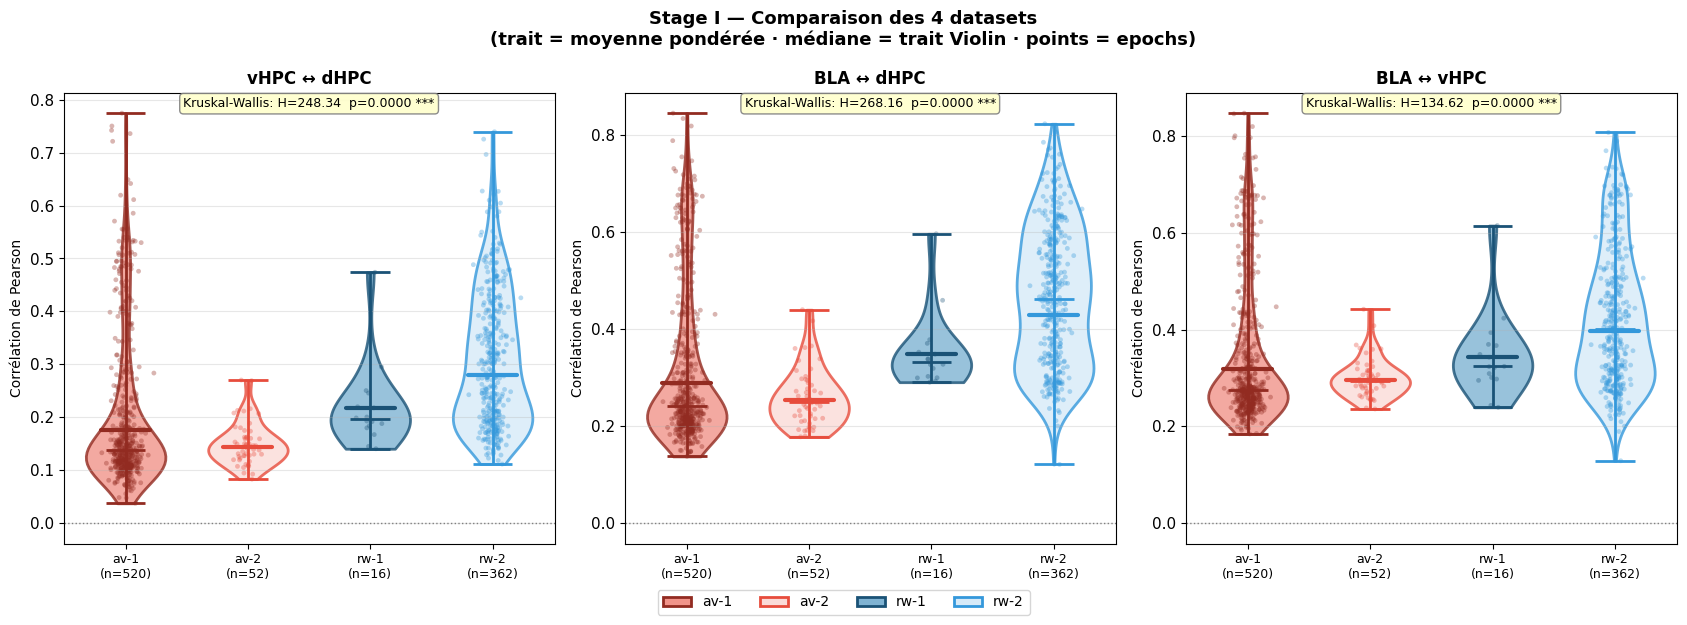

In [4]:
def violin_4datasets(stage, title_suffix=''):
    """Violin plots des 4 datasets côte à côte pour un stage donné."""
    fig, axes = plt.subplots(1, 3, figsize=(17, 6))

    for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[pi]
        positions = [1, 2, 3, 4]
        all_data  = [corr_cache[(name, stage, pair_label)][0] for name in DATASET_NAMES]
        all_w     = [corr_cache[(name, stage, pair_label)][1] for name in DATASET_NAMES]

        for pos, name, d, w in zip(positions, DATASET_NAMES, all_data, all_w):
            if len(d) < 2:
                continue

            vp = ax.violinplot([d], positions=[pos], showmedians=True, widths=0.65)
            vp['bodies'][0].set_facecolor(FACE_COLORS[name])
            vp['bodies'][0].set_edgecolor(COLORS[name])
            vp['bodies'][0].set_linewidth(2)
            vp['bodies'][0].set_alpha(0.8)
            for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
                vp[part].set_color(COLORS[name])
                vp[part].set_linewidth(2)

            # Scatter jitter
            np.random.seed(42)
            ax.scatter(np.random.normal(pos, 0.06, len(d)), d,
                       alpha=0.35, s=12, color=COLORS[name], edgecolors='none')

            # Moyenne pondérée
            if len(w) > 0:
                wm, _ = weighted_mean_std(d, w)
                ax.plot([pos - 0.2, pos + 0.2], [wm, wm],
                        color=COLORS[name], lw=3, solid_capstyle='round')

        # Tests Kruskal-Wallis global
        valid_groups = [d for d in all_data if len(d) >= 3]
        if len(valid_groups) >= 2:
            kw_stat, kw_p = stats.kruskal(*valid_groups)
            ax.text(0.5, 0.99,
                    f'Kruskal-Wallis: H={kw_stat:.2f}  p={kw_p:.4f} {sig_label(kw_p)}',
                    transform=ax.transAxes, ha='center', va='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='#FFFFCC' if kw_p < 0.05 else '#F0F0F0',
                              alpha=0.9, edgecolor='gray'))

        ax.set_xticks(positions)
        ax.set_xticklabels(
            [f"{name}\n(n={len(corr_cache[(name, stage, pair_label)][0])})"
             for name in DATASET_NAMES],
            fontsize=9
        )
        ax.set_ylabel('Corrélation de Pearson', fontsize=10)
        ax.set_title(pair_label, fontsize=12, fontweight='bold')
        ax.axhline(0, color='gray', linestyle=':', lw=1)
        ax.grid(True, alpha=0.3, axis='y')

    # Légende
    legend_patches = [
        mpatches.Patch(facecolor=FACE_COLORS[name], edgecolor=COLORS[name],
                       linewidth=2, label=name)
        for name in DATASET_NAMES
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=4,
               fontsize=10, frameon=True,
               bbox_to_anchor=(0.5, -0.04))

    plt.suptitle(f'{stage} — Comparaison des 4 datasets{title_suffix}\n'
                 '(trait = moyenne pondérée · médiane = trait Violin · points = epochs)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


violin_4datasets('Stage I')

## Figure 2 — Comparaison des 4 datasets : Stage II

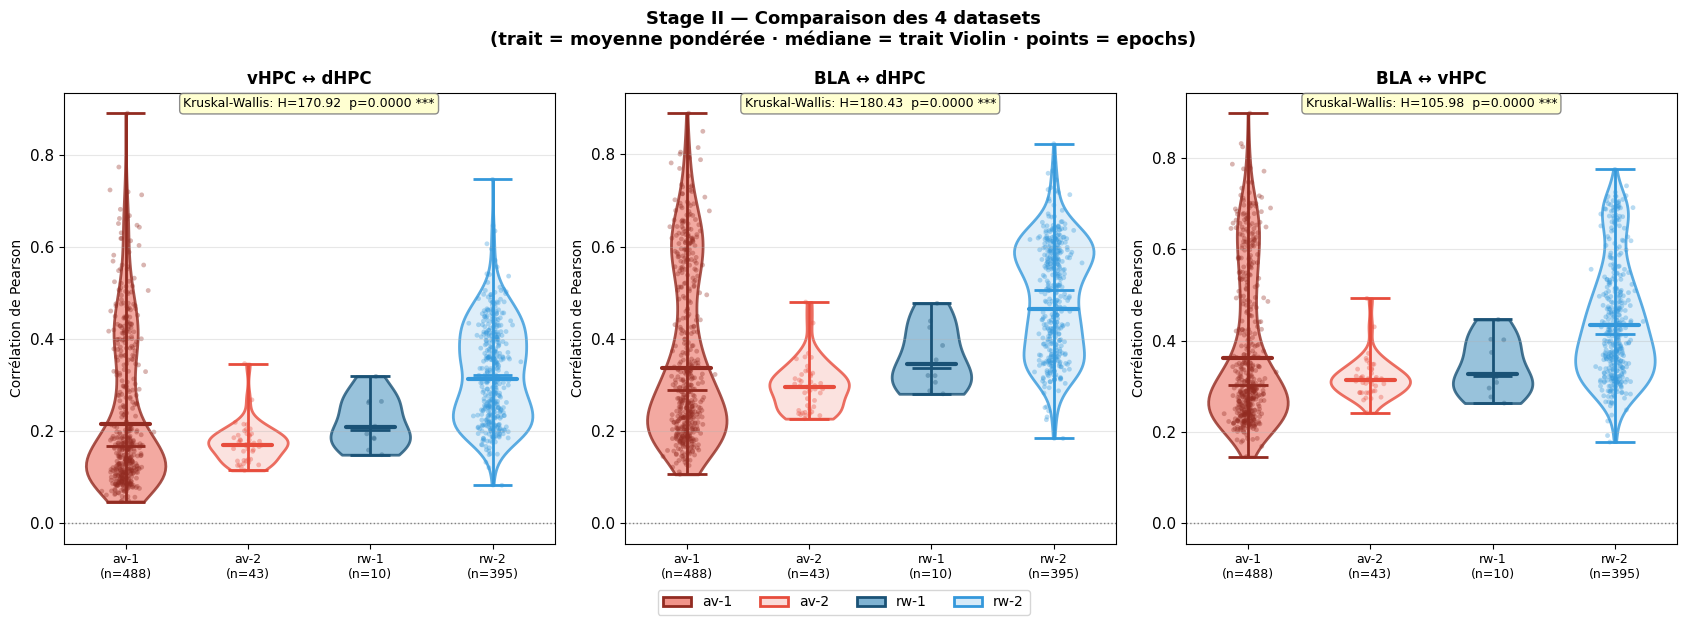

In [5]:
violin_4datasets('Stage II')

## Figure 3 — Stage I vs Stage II au sein de chaque dataset

Pour chaque dataset, comparaison directe de la distribution Stage I vs Stage II (4 × 3 panneaux).

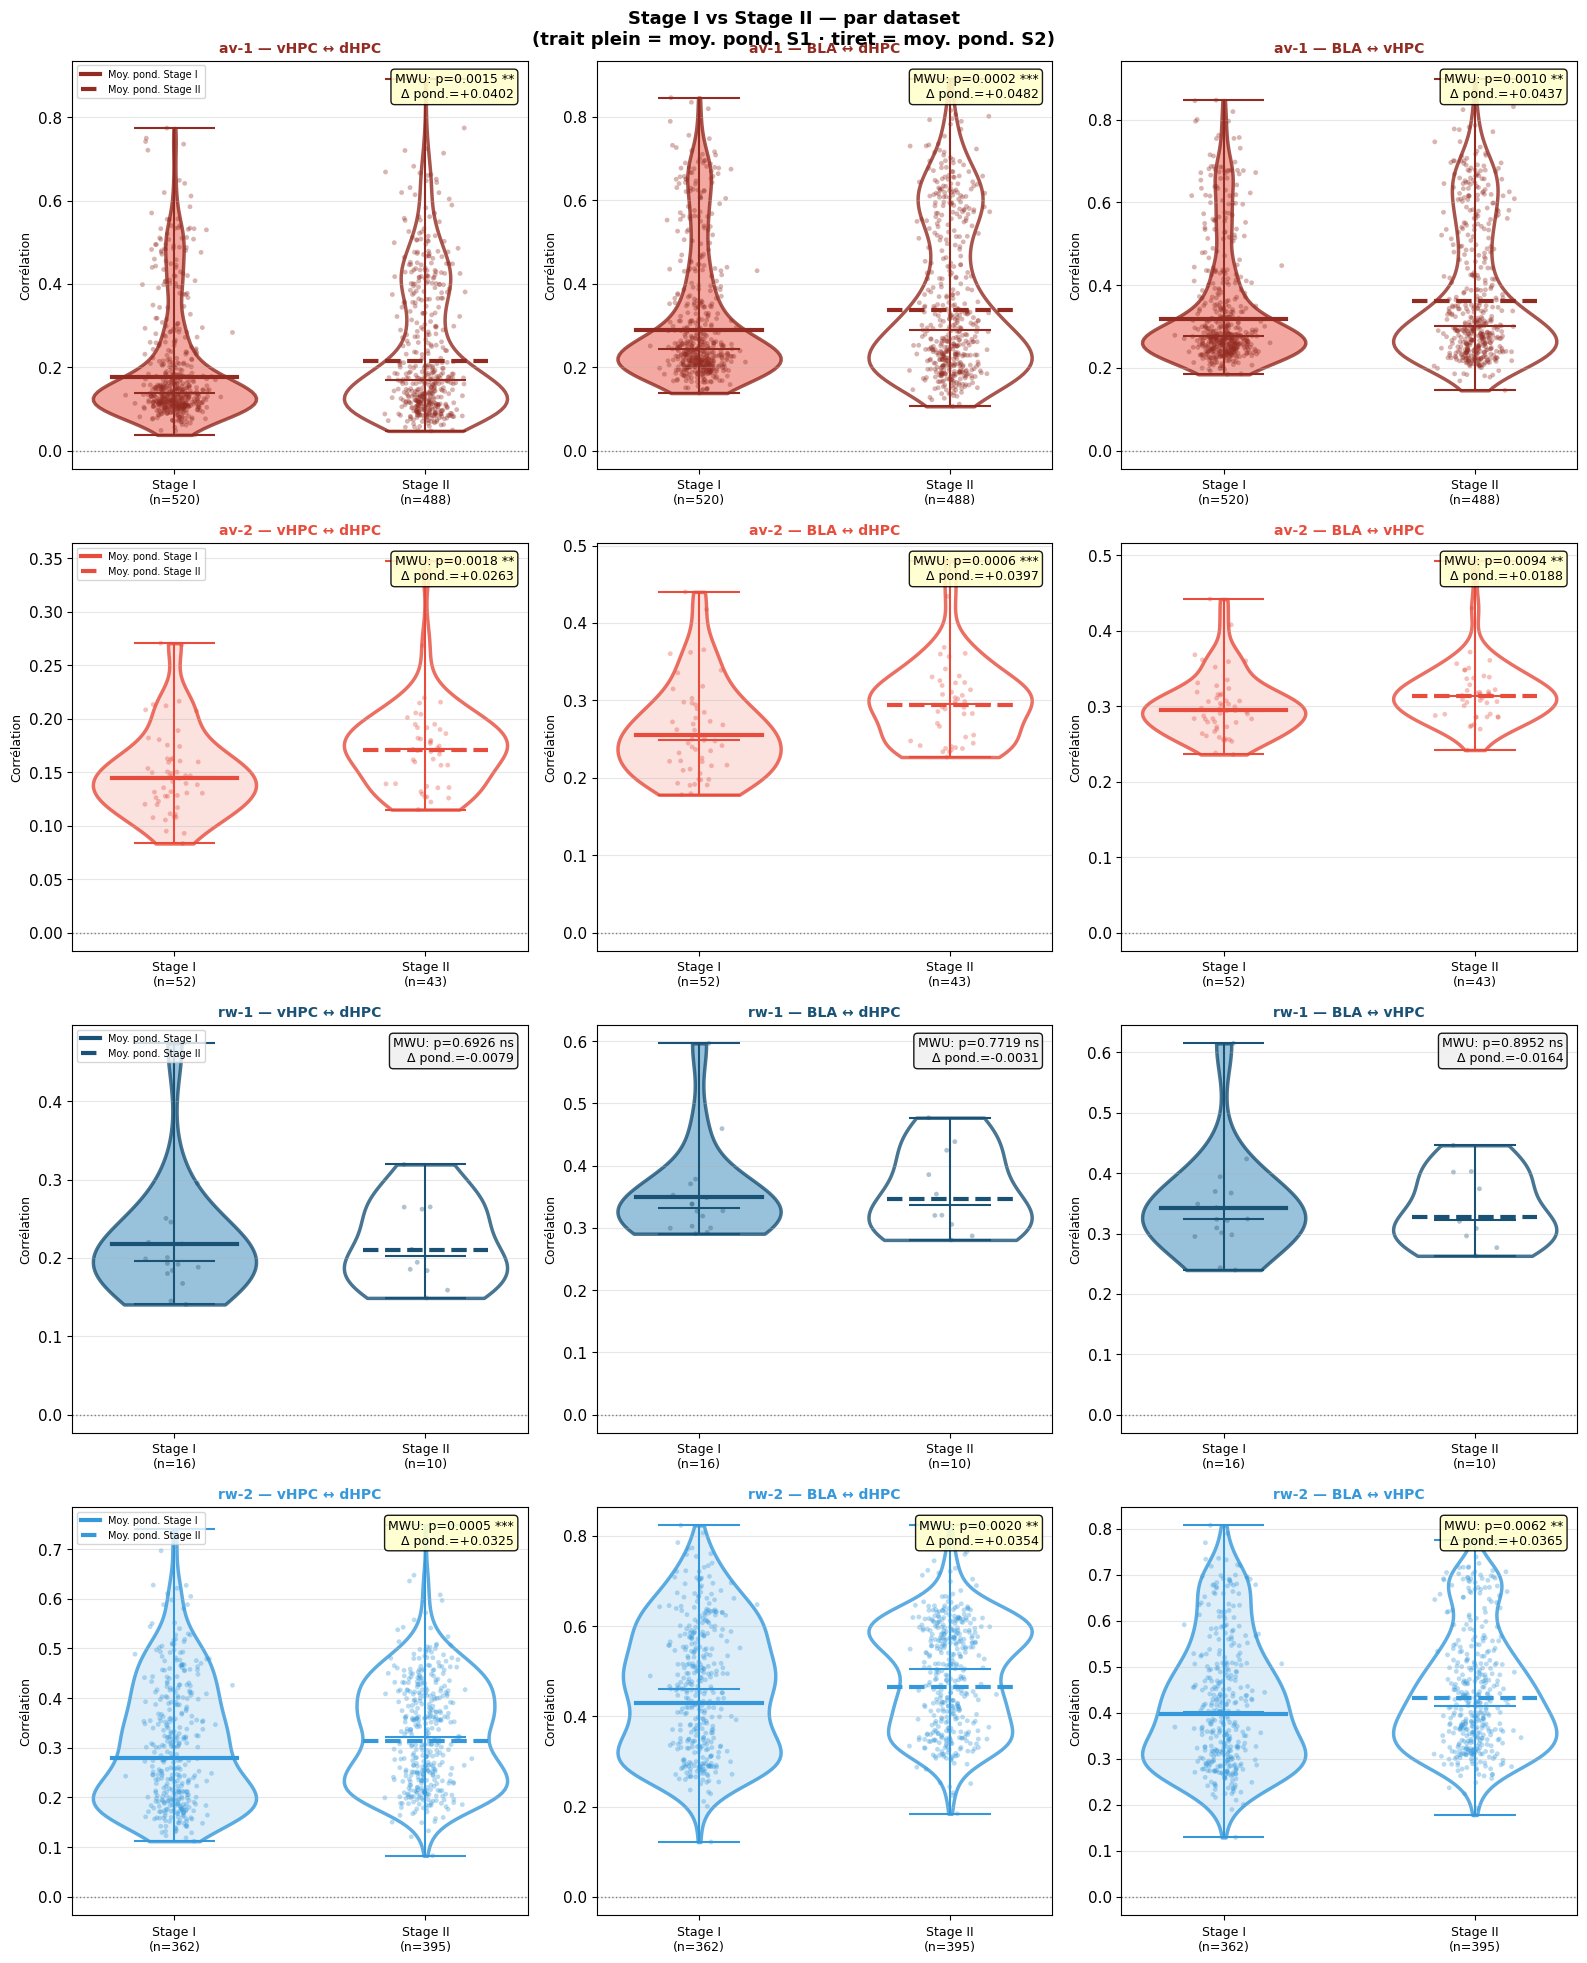

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(16, 20))

for ri, name in enumerate(DATASET_NAMES):
    for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[ri, pi]

        d_s1, w_s1 = corr_cache[(name, 'Stage I',  pair_label)]
        d_s2, w_s2 = corr_cache[(name, 'Stage II', pair_label)]

        if len(d_s1) < 2 or len(d_s2) < 2:
            ax.text(0.5, 0.5, 'Données\ninsuffisantes',
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{name} — {pair_label}', fontsize=10, fontweight='bold')
            continue

        c_s1 = COLORS[name]
        # Stage II légèrement plus clair
        c_s2 = FACE_COLORS[name]

        vp = ax.violinplot([d_s1, d_s2], positions=[1, 2], showmedians=True, widths=0.65)
        for i, (fc, ec) in enumerate([(FACE_COLORS[name], COLORS[name]),
                                       ('#ffffff', COLORS[name])]):
            vp['bodies'][i].set_facecolor(fc)
            vp['bodies'][i].set_edgecolor(ec)
            vp['bodies'][i].set_linewidth(2.5)
            vp['bodies'][i].set_alpha(0.8)
        for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
            vp[part].set_color(COLORS[name])
            vp[part].set_linewidth(1.5)

        # Scatter
        np.random.seed(42)
        for pos, d in [(1, d_s1), (2, d_s2)]:
            ax.scatter(np.random.normal(pos, 0.06, len(d)), d,
                       alpha=0.35, s=12, color=COLORS[name], edgecolors='none')

        # Moyennes pondérées
        wm1, _ = weighted_mean_std(d_s1, w_s1)
        wm2, _ = weighted_mean_std(d_s2, w_s2)
        ax.plot([0.75, 1.25], [wm1, wm1], color=COLORS[name], lw=3)
        ax.plot([1.75, 2.25], [wm2, wm2], color=COLORS[name], lw=3, linestyle='--')

        # Test MWU
        _, p = mwu(d_s1, d_s2)
        if not np.isnan(p):
            delta = wm2 - wm1
            ann   = f"MWU: p={p:.4f} {sig_label(p)}\nΔ pond.={delta:+.4f}"
            ax.text(0.97, 0.97, ann, transform=ax.transAxes, fontsize=9,
                    va='top', ha='right',
                    bbox=dict(boxstyle='round',
                              facecolor='#FFFFCC' if p < 0.05 else '#F0F0F0',
                              alpha=0.9, edgecolor='black'))

        ax.set_xticks([1, 2])
        ax.set_xticklabels([f'Stage I\n(n={len(d_s1)})',
                            f'Stage II\n(n={len(d_s2)})'], fontsize=9)
        ax.set_ylabel('Corrélation', fontsize=9)
        ax.set_title(f'{name} — {pair_label}', fontsize=10, fontweight='bold',
                     color=COLORS[name])
        ax.axhline(0, color='gray', linestyle=':', lw=1)
        ax.grid(True, alpha=0.3, axis='y')

        # Légende dans le premier panneau de chaque ligne
        if pi == 0:
            ax.plot([], [], color=COLORS[name], lw=3, label='Moy. pond. Stage I')
            ax.plot([], [], color=COLORS[name], lw=3, ls='--', label='Moy. pond. Stage II')
            ax.legend(fontsize=7, loc='upper left')

plt.suptitle('Stage I vs Stage II — par dataset\n'
             '(trait plein = moy. pond. S1 · tiret = moy. pond. S2)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Figure 4 — KDE pondérées : toutes les distributions

Pour chaque paire, les 8 distributions (4 datasets × 2 stages) superposées.  
Lignes continues = Stage I · tirets = Stage II.

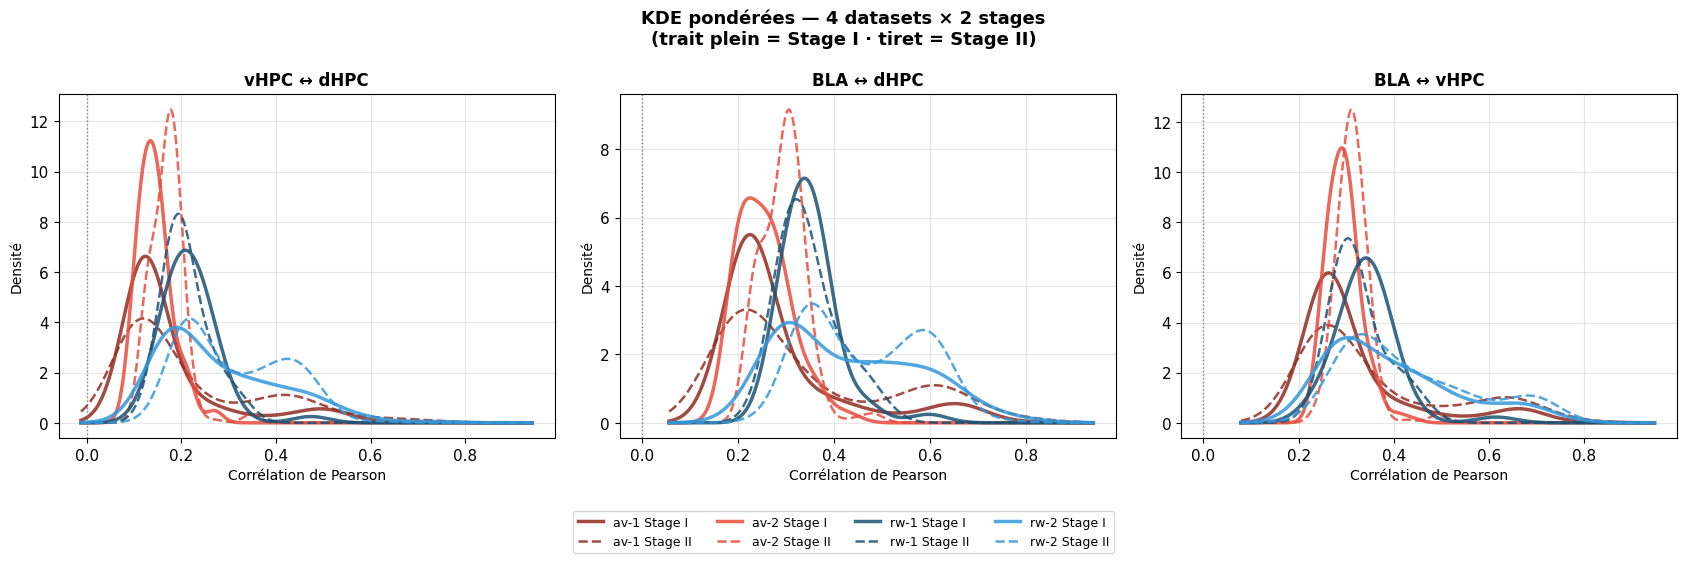

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
    ax = axes[pi]

    # Plage commune
    all_vals = np.concatenate([
        corr_cache[(name, stage, pair_label)][0]
        for name in DATASET_NAMES for stage in STAGES
        if len(corr_cache[(name, stage, pair_label)][0]) > 1
    ])
    x = np.linspace(all_vals.min() - 0.05, all_vals.max() + 0.05, 500)

    for name in DATASET_NAMES:
        for stage, ls in [('Stage I', '-'), ('Stage II', '--')]:
            d, w = corr_cache[(name, stage, pair_label)]
            if len(d) < 3:
                continue
            kde = stats.gaussian_kde(d, weights=w / w.sum(), bw_method='scott')
            lw  = 2.5 if ls == '-' else 1.8
            ax.plot(x, kde(x), color=COLORS[name], lw=lw, linestyle=ls,
                    label=f'{name} {stage}', alpha=0.85)

    ax.axvline(0, color='gray', linestyle=':', lw=1)
    ax.set_xlabel('Corrélation de Pearson', fontsize=10)
    ax.set_ylabel('Densité', fontsize=10)
    ax.set_title(pair_label, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Légende commune
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=9,
           frameon=True, bbox_to_anchor=(0.5, -0.12))

plt.suptitle('KDE pondérées — 4 datasets × 2 stages\n'
             '(trait plein = Stage I · tiret = Stage II)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Tests statistiques pairwise entre les 4 datasets

Pour chaque stage et chaque paire de régions :
- **Kruskal-Wallis** : test global (H0 : toutes les distributions identiques)
- **Mann-Whitney U** : comparaisons pairwise entre les 4 datasets (C(4,2) = 6 paires)

In [8]:
dataset_pairs = list(combinations(DATASET_NAMES, 2))  # 6 paires

for stage in STAGES:
    print(f"\n{'='*100}")
    print(f"  {stage}")
    print(f"{'='*100}")

    for n1, n2, pair_label, _ in PAIRS:
        groups = {name: corr_cache[(name, stage, pair_label)][0]
                  for name in DATASET_NAMES}

        # Kruskal-Wallis
        valid_groups = [g for g in groups.values() if len(g) >= 3]
        if len(valid_groups) >= 2:
            kw_stat, kw_p = stats.kruskal(*valid_groups)
            print(f"\n  {pair_label}")
            print(f"  Kruskal-Wallis : H={kw_stat:.3f}  p={kw_p:.4e}  {sig_label(kw_p)}")
        else:
            print(f"\n  {pair_label}  (données insuffisantes)")
            continue

        # Moyennes pondérées
        print(f"  {'Dataset':<8}  {'n':>5}  {'Moy. pond.':>12}  {'Médiane':>10}")
        for name in DATASET_NAMES:
            d, w = corr_cache[(name, stage, pair_label)]
            wm, _ = weighted_mean_std(d, w) if len(d) > 0 else (np.nan, np.nan)
            print(f"  {name:<8}  {len(d):>5}  {wm:>+12.4f}  {np.median(d):>+10.4f}")

        # MWU pairwise
        print(f"  {'Comparaison':<14}  {'MWU stat':>10}  {'p':>9}  {'Sig':>5}  "
              f"{'Δ moy. pond.':>14}")
        print(f"  {'-'*58}")
        for (na, nb) in dataset_pairs:
            da, wa = corr_cache[(na, stage, pair_label)]
            db, wb = corr_cache[(nb, stage, pair_label)]
            u, p = mwu(da, db)
            if np.isnan(p):
                continue
            wma, _ = weighted_mean_std(da, wa)
            wmb, _ = weighted_mean_std(db, wb)
            delta = wma - wmb
            print(f"  {na} vs {nb:<6}  {u:>10.0f}  {p:>9.4f}  {sig_label(p):>5}  "
                  f"{delta:>+14.4f}")


  Stage I

  vHPC ↔ dHPC
  Kruskal-Wallis : H=248.341  p=1.4953e-53  ***
  Dataset       n    Moy. pond.     Médiane
  av-1        520       +0.1755     +0.1382
  av-2         52       +0.1444     +0.1453
  rw-1         16       +0.2180     +0.1959
  rw-2        362       +0.2801     +0.2794
  Comparaison       MWU stat          p    Sig    Δ moy. pond.
  ----------------------------------------------------------
  av-1 vs av-2         13677     0.8905     ns         +0.0311
  av-1 vs rw-1          2378     0.0035     **         -0.0425
  av-1 vs rw-2         39343     0.0000    ***         -0.1046
  av-2 vs rw-1           128     0.0000    ***         -0.0736
  av-2 vs rw-2          1634     0.0000    ***         -0.1357
  rw-1 vs rw-2          1683     0.0046     **         -0.0621

  BLA ↔ dHPC
  Kruskal-Wallis : H=268.159  p=7.7213e-58  ***
  Dataset       n    Moy. pond.     Médiane
  av-1        520       +0.2890     +0.2424
  av-2         52       +0.2548     +0.2490
  rw-1    

## Figure 5 — Résumé : moyennes pondérées Stage I vs Stage II par dataset

Barres groupées montrant la moyenne pondérée pour chaque dataset × stage × paire.

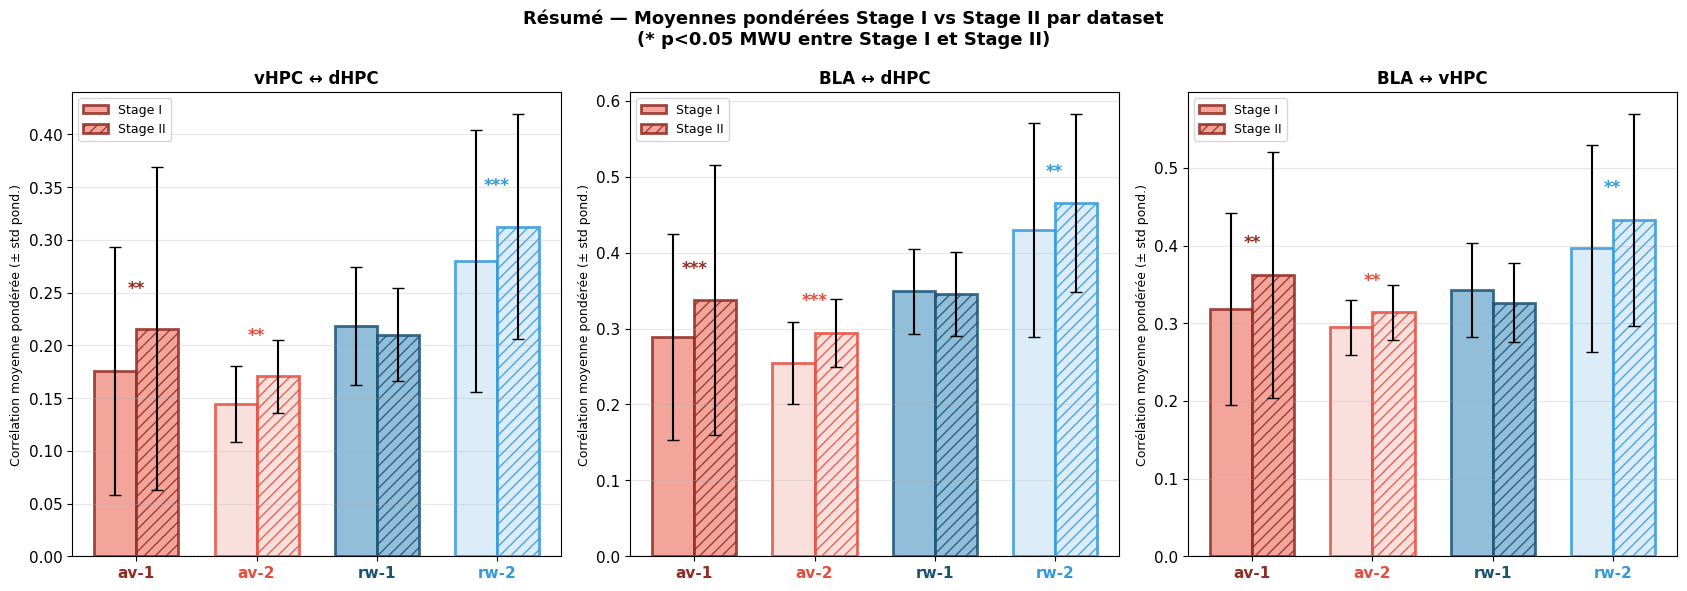

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(17, 6))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
    ax = axes[pi]

    x   = np.arange(len(DATASET_NAMES))
    w   = 0.35

    for si, (stage, hatch) in enumerate([('Stage I', ''), ('Stage II', '///')]):
        means = []
        errs  = []
        for name in DATASET_NAMES:
            d, wt = corr_cache[(name, stage, pair_label)]
            if len(d) > 0:
                m, s = weighted_mean_std(d, wt)
            else:
                m, s = np.nan, 0
            means.append(m)
            errs.append(s)

        offset = -w/2 if si == 0 else w/2
        bars = ax.bar(
            x + offset, means, w,
            yerr=errs, capsize=4,
            color=[FACE_COLORS[name] for name in DATASET_NAMES],
            edgecolor=[COLORS[name] for name in DATASET_NAMES],
            linewidth=2, hatch=hatch,
            label=stage, alpha=0.85, error_kw=dict(lw=1.5)
        )

        # Annotations MWU Stage I vs Stage II
        for xi, name in zip(x, DATASET_NAMES):
            if si == 1:  # annoter après avoir tracé Stage II
                da, wa = corr_cache[(name, 'Stage I',  pair_label)]
                db, wb = corr_cache[(name, 'Stage II', pair_label)]
                _, p = mwu(da, db)
                if not np.isnan(p) and p < 0.05:
                    ymax = max(
                        weighted_mean_std(da, wa)[0] if len(da)>0 else 0,
                        weighted_mean_std(db, wb)[0] if len(db)>0 else 0
                    )
                    ax.text(xi, ymax + 0.03, sig_label(p),
                            ha='center', va='bottom', fontsize=12,
                            fontweight='bold', color=COLORS[name])

    ax.set_xticks(x)
    ax.set_xticklabels(DATASET_NAMES, fontsize=11)
    ax.set_ylabel('Corrélation moyenne pondérée (± std pond.)', fontsize=9)
    ax.set_title(pair_label, fontsize=12, fontweight='bold')
    ax.axhline(0, color='gray', linestyle=':', lw=1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)

    # Couleurs des xtick labels
    for tick, name in zip(ax.get_xticklabels(), DATASET_NAMES):
        tick.set_color(COLORS[name])
        tick.set_fontweight('bold')

plt.suptitle('Résumé — Moyennes pondérées Stage I vs Stage II par dataset\n'
             '(* p<0.05 MWU entre Stage I et Stage II)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Figure 6 — Rewarded vs Aversive : shift Stage II − Stage I

Les datasets sont poolés : **Aversive** = av-1 + av-2 (rouge), **Rewarded** = rw-1 + rw-2 (bleu).

### Comment lire la figure

**Ligne du haut — Violin plots (4 violins par paire)**
- Chaque paire de violins montre Stage I (couleur pleine) vs Stage II (hachuré blanc) pour une condition.
- Le **trait horizontal** = moyenne pondérée par durée d'epoch.
- Le **crochet coloré entre S1 et S2** (MWU bilatéral) indique si les corrélations changent significativement entre les deux stages *au sein d'une même condition* (Δ = différence des moyennes pondérées).

**Ligne du bas — Courbe de différence de densité KDE(Stage II) − KDE(Stage I)**
- Une valeur **positive** à un r donné signifie que Stage II a plus d'epochs à cette corrélation que Stage I.
- Une valeur **négative** signifie l'inverse.
- La **boîte en bas à droite** contient le **test d'interaction** : est-ce que le shift S1→S2 est différent entre les deux conditions ?

### Test d'interaction (boîte en bas à droite)

La statistique testée est :

> **Δ_RW − Δ_AV** = (mean_S2_RW − mean_S1_RW) − (mean_S2_AV − mean_S1_AV)

Le test est un **test de permutation** (10 000 itérations) : les étiquettes de condition (Rewarded / Aversive) sont réassignées aléatoirement à chaque stage séparément, ce qui génère une distribution nulle de la différence de shifts.

### Interprétation rapide
| Observation | Signification |
|-------------|---------------|
| Δ_RW > 0, Δ_AV ≈ 0 | Le passage S1→S2 augmente les corrélations uniquement en condition Rewarded |
| Δ_RW − Δ_AV significatif | L'effet du sleep stage sur les corrélations dépend de la condition (interaction) |
| Courbe KDE Rewarded décalée à droite | La densité de probabilité se déplace davantage vers des corrélations élevées en Rewarded |
| Δ_RW − Δ_AV non significatif | Les deux conditions présentent le même changement S1→S2 |

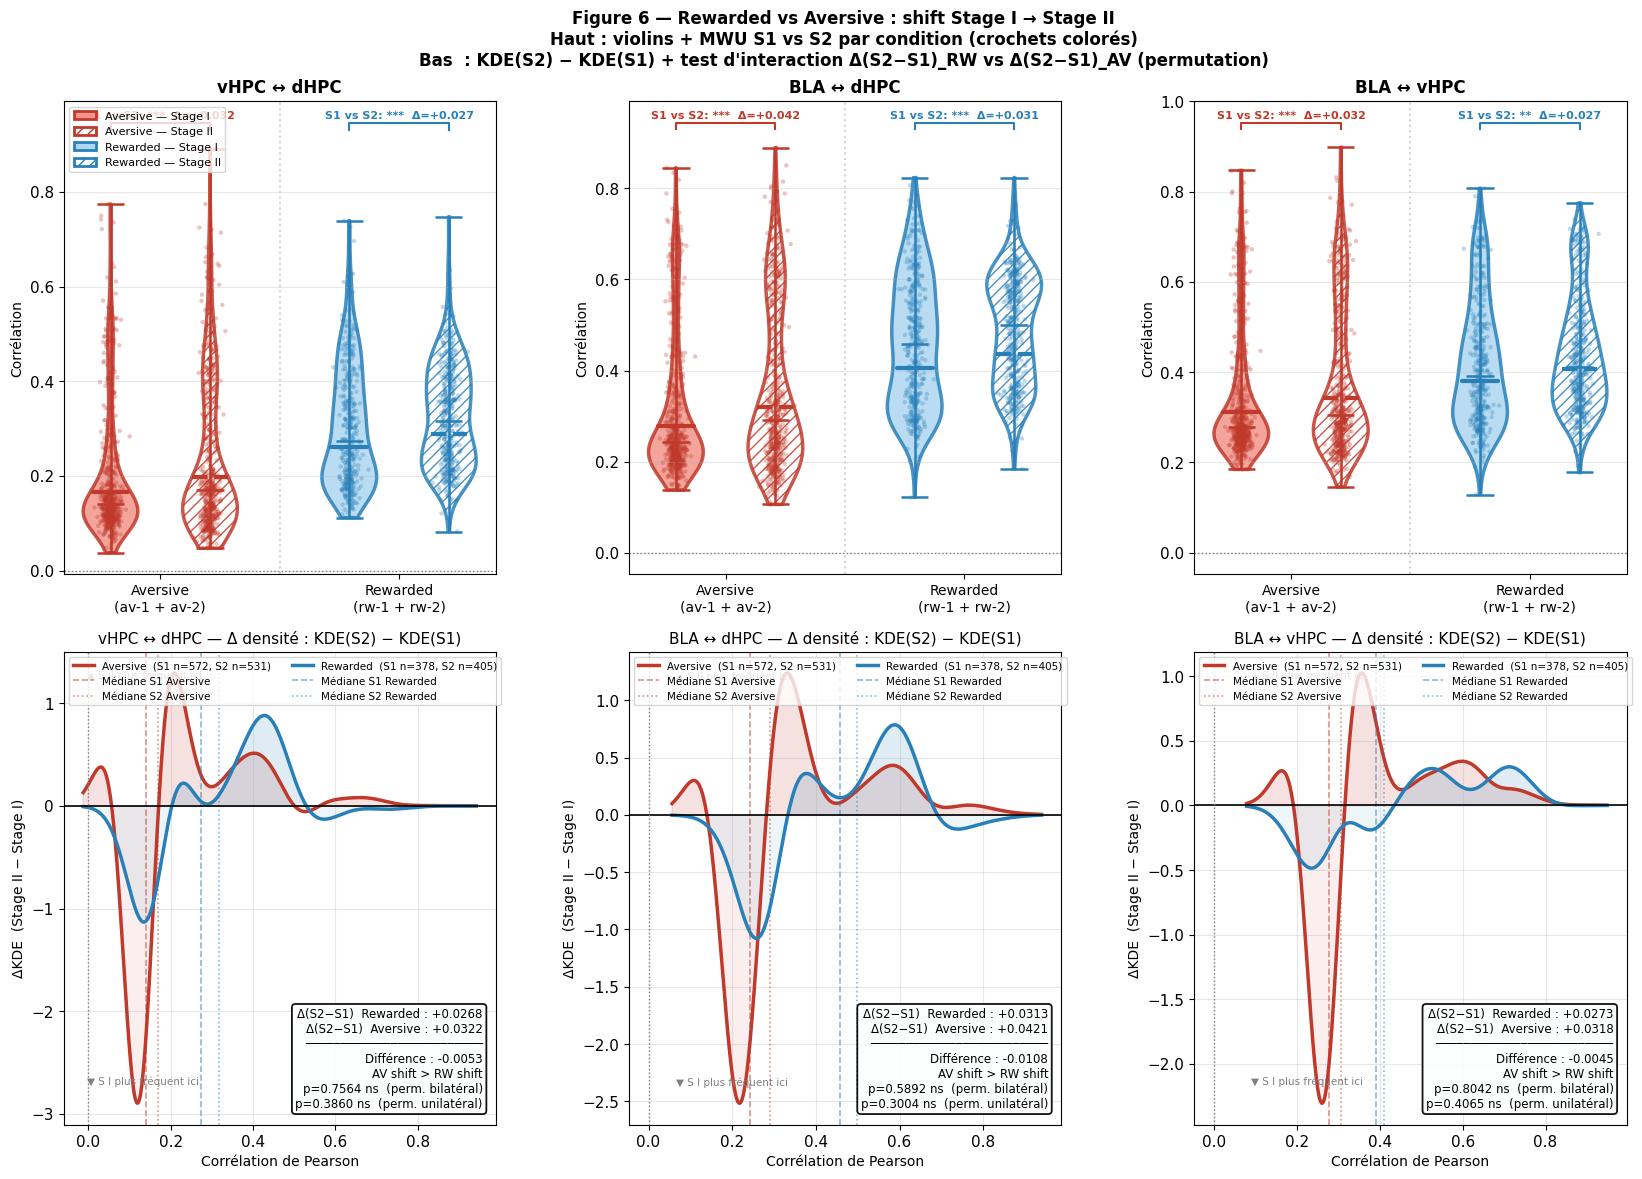

In [10]:
# --- Pool aversive (av-1 + av-2) et rewarded (rw-1 + rw-2) ---
CONDITIONS = {
    'Aversive': ['av-1', 'av-2'],
    'Rewarded': ['rw-1', 'rw-2'],
}
COND_COLORS = {'Aversive': '#c0392b', 'Rewarded': '#2980b9'}
COND_FACE   = {'Aversive': '#f1948a', 'Rewarded': '#aed6f1'}

pooled_cache = {}
for cond, names in CONDITIONS.items():
    for stage in STAGES:
        for _, _, pair_label, _ in PAIRS:
            all_c = np.concatenate([corr_cache[(n, stage, pair_label)][0] for n in names])
            all_w = np.concatenate([corr_cache[(n, stage, pair_label)][1] for n in names])
            pooled_cache[(cond, stage, pair_label)] = (all_c, all_w)


def mwu_one_sided(a, b, alternative='greater'):
    """MWU unilatéral. alternative='greater' → H1 : a > b."""
    if len(a) < 3 or len(b) < 3:
        return np.nan, np.nan
    stat, p = stats.mannwhitneyu(a, b, alternative=alternative)
    return stat, p


def test_interaction_shift(d_s1_rw, w_s1_rw, d_s2_rw, w_s2_rw,
                           d_s1_av, w_s1_av, d_s2_av, w_s2_av,
                           n_perm=10000):
    """
    Test si Δ(S2−S1) diffère entre Rewarded et Aversive.
    Stat observée : (wmean_S2_RW − wmean_S1_RW) − (wmean_S2_AV − wmean_S1_AV)
    Permutation : réassigner les étiquettes de condition en gardant les stages fixes.
    """
    wm_s1_rw, _ = weighted_mean_std(d_s1_rw, w_s1_rw)
    wm_s2_rw, _ = weighted_mean_std(d_s2_rw, w_s2_rw)
    wm_s1_av, _ = weighted_mean_std(d_s1_av, w_s1_av)
    wm_s2_av, _ = weighted_mean_std(d_s2_av, w_s2_av)
    delta_rw = wm_s2_rw - wm_s1_rw
    delta_av = wm_s2_av - wm_s1_av
    observed = delta_rw - delta_av   # stat d'interaction

    # Pooler par stage, puis réassigner les conditions aléatoirement
    pool_s1   = np.concatenate([d_s1_rw, d_s1_av])
    pool_s2   = np.concatenate([d_s2_rw, d_s2_av])
    w_pool_s1 = np.concatenate([w_s1_rw, w_s1_av])
    w_pool_s2 = np.concatenate([w_s2_rw, w_s2_av])
    n_rw_s1, n_rw_s2 = len(d_s1_rw), len(d_s2_rw)

    rng = np.random.default_rng(42)
    perm_stats = np.empty(n_perm)
    for i in range(n_perm):
        idx1 = rng.permutation(len(pool_s1))
        idx2 = rng.permutation(len(pool_s2))

        a1, wa1 = pool_s1[idx1[:n_rw_s1]], w_pool_s1[idx1[:n_rw_s1]]
        b1, wb1 = pool_s1[idx1[n_rw_s1:]], w_pool_s1[idx1[n_rw_s1:]]
        a2, wa2 = pool_s2[idx2[:n_rw_s2]], w_pool_s2[idx2[:n_rw_s2]]
        b2, wb2 = pool_s2[idx2[n_rw_s2:]], w_pool_s2[idx2[n_rw_s2:]]

        wm_a1, _ = weighted_mean_std(a1, wa1)
        wm_a2, _ = weighted_mean_std(a2, wa2)
        wm_b1, _ = weighted_mean_std(b1, wb1)
        wm_b2, _ = weighted_mean_std(b2, wb2)
        perm_stats[i] = (wm_a2 - wm_a1) - (wm_b2 - wm_b1)

    p_two   = np.mean(np.abs(perm_stats) >= np.abs(observed))
    p_rw_gt = np.mean(perm_stats >= observed)   # H1 : Δ_RW > Δ_AV
    return observed, delta_rw, delta_av, p_two, p_rw_gt


# ── Figure : 2 lignes × 3 colonnes ──────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(17, 12))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):

    # ── Ligne 1 : violins ────────────────────────────────────────────────────
    ax_v = axes[0, pi]

    configs = [
        ('Aversive', 'Stage I',  1  ),
        ('Aversive', 'Stage II', 2  ),
        ('Rewarded', 'Stage I',  3.4),
        ('Rewarded', 'Stage II', 4.4),
    ]

    for cond, stage, pos in configs:
        d, w = pooled_cache[(cond, stage, pair_label)]
        if len(d) < 2:
            continue
        fc    = COND_FACE[cond] if stage == 'Stage I' else '#ffffff'
        ec    = COND_COLORS[cond]
        hatch = ''              if stage == 'Stage I' else '///'

        vp = ax_v.violinplot([d], positions=[pos], showmedians=True, widths=0.55)
        vp['bodies'][0].set_facecolor(fc)
        vp['bodies'][0].set_edgecolor(ec)
        vp['bodies'][0].set_linewidth(2.5)
        vp['bodies'][0].set_alpha(0.85)
        vp['bodies'][0].set_hatch(hatch)
        for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
            vp[part].set_color(ec); vp[part].set_linewidth(1.8)

        np.random.seed(42)
        ax_v.scatter(np.random.normal(pos, 0.05, len(d)), d,
                     alpha=0.3, s=10, color=ec, edgecolors='none')

        wm, _ = weighted_mean_std(d, w)
        ls = '-' if stage == 'Stage I' else '--'
        ax_v.plot([pos - 0.18, pos + 0.18], [wm, wm],
                  color=ec, lw=3, linestyle=ls, solid_capstyle='round')

    # --- Crochets : S1 vs S2 au sein de chaque condition (MWU bilatéral) ---
    y_top_all = max(
        pooled_cache[(c, s, pair_label)][0].max()
        for c in CONDITIONS for s in STAGES
        if len(pooled_cache[(c, s, pair_label)][0]) > 0
    )
    bracket_base = y_top_all + 0.04

    for cond, x_mid, x_l, x_r in [('Aversive', 1.5, 1, 2),
                                    ('Rewarded', 3.9, 3.4, 4.4)]:
        d1, w1 = pooled_cache[(cond, 'Stage I',  pair_label)]
        d2, w2 = pooled_cache[(cond, 'Stage II', pair_label)]
        _, p = mwu(d1, d2)
        if not np.isnan(p):
            wm1, _ = weighted_mean_std(d1, w1)
            wm2, _ = weighted_mean_std(d2, w2)
            delta = wm2 - wm1
            yb = bracket_base
            ax_v.plot([x_l, x_l, x_r, x_r], [yb, yb+.015, yb+.015, yb],
                      color=COND_COLORS[cond], lw=1.5)
            ax_v.text(x_mid, yb + 0.02,
                      f'S1 vs S2: {sig_label(p)}  Δ={delta:+.3f}',
                      ha='center', va='bottom', fontsize=8,
                      color=COND_COLORS[cond], fontweight='bold')

    ax_v.axvline(2.7, color='lightgray', lw=1.5, linestyle=':')
    ax_v.set_xticks([1.5, 3.9])
    ax_v.set_xticklabels(['Aversive\n(av-1 + av-2)', 'Rewarded\n(rw-1 + rw-2)'], fontsize=10)
    ax_v.set_ylabel('Corrélation', fontsize=10)
    ax_v.set_title(pair_label, fontsize=12, fontweight='bold')
    ax_v.axhline(0, color='gray', linestyle=':', lw=1)
    ax_v.grid(True, alpha=0.3, axis='y')

    if pi == 0:
        from matplotlib.patches import Patch
        legend_els = [
            Patch(fc=COND_FACE['Aversive'], ec=COND_COLORS['Aversive'], lw=2,
                  label='Aversive — Stage I'),
            Patch(fc='white', ec=COND_COLORS['Aversive'], lw=2, hatch='///',
                  label='Aversive — Stage II'),
            Patch(fc=COND_FACE['Rewarded'], ec=COND_COLORS['Rewarded'], lw=2,
                  label='Rewarded — Stage I'),
            Patch(fc='white', ec=COND_COLORS['Rewarded'], lw=2, hatch='///',
                  label='Rewarded — Stage II'),
        ]
        ax_v.legend(handles=legend_els, fontsize=8, loc='upper left')

    # ── Ligne 2 : KDE(S2) − KDE(S1) + test d'interaction Δ_RW vs Δ_AV ─────
    ax_k = axes[1, pi]

    all_vals = np.concatenate([
        pooled_cache[(cond, stage, pair_label)][0]
        for cond in CONDITIONS for stage in STAGES
        if len(pooled_cache[(cond, stage, pair_label)][0]) > 1
    ])
    x_grid = np.linspace(all_vals.min() - 0.05, all_vals.max() + 0.05, 500)

    for cond in CONDITIONS:
        d1, w1 = pooled_cache[(cond, 'Stage I',  pair_label)]
        d2, w2 = pooled_cache[(cond, 'Stage II', pair_label)]
        if len(d1) < 3 or len(d2) < 3:
            continue
        kde1 = stats.gaussian_kde(d1, weights=w1/w1.sum(), bw_method='scott')
        kde2 = stats.gaussian_kde(d2, weights=w2/w2.sum(), bw_method='scott')
        diff = kde2(x_grid) - kde1(x_grid)

        color = COND_COLORS[cond]
        ax_k.plot(x_grid, diff, color=color, lw=2.5,
                  label=f'{cond}  (S1 n={len(d1)}, S2 n={len(d2)})')
        ax_k.fill_between(x_grid, diff, 0, where=diff > 0, alpha=0.15, color=color)
        ax_k.fill_between(x_grid, diff, 0, where=diff < 0, alpha=0.08, color=color)
        ax_k.axvline(np.median(d1), color=color, lw=1.2, linestyle='--', alpha=0.55,
                     label=f'Médiane S1 {cond}')
        ax_k.axvline(np.median(d2), color=color, lw=1.2, linestyle=':',  alpha=0.55,
                     label=f'Médiane S2 {cond}')

    # --- Test d'interaction : Δ(S2−S1)_RW vs Δ(S2−S1)_AV (permutation) ---
    d_s1_rw, w_s1_rw = pooled_cache[('Rewarded', 'Stage I',  pair_label)]
    d_s2_rw, w_s2_rw = pooled_cache[('Rewarded', 'Stage II', pair_label)]
    d_s1_av, w_s1_av = pooled_cache[('Aversive', 'Stage I',  pair_label)]
    d_s2_av, w_s2_av = pooled_cache[('Aversive', 'Stage II', pair_label)]

    obs, delta_rw, delta_av, p_two, p_rw_gt = test_interaction_shift(
        d_s1_rw, w_s1_rw, d_s2_rw, w_s2_rw,
        d_s1_av, w_s1_av, d_s2_av, w_s2_av
    )
    direction = 'RW shift > AV shift' if obs > 0 else 'AV shift > RW shift'
    p_dir = p_rw_gt if obs > 0 else (1 - p_rw_gt)

    ann_text = (
        f'Δ(S2−S1)  Rewarded : {delta_rw:+.4f}\n'
        f'Δ(S2−S1)  Aversive : {delta_av:+.4f}\n'
        f'─────────────────────────\n'
        f'Différence : {obs:+.4f}\n'
        f'{direction}\n'
        f'p={p_two:.4f} {sig_label(p_two)}  (perm. bilatéral)\n'
        f'p={p_dir:.4f} {sig_label(p_dir)}  (perm. unilatéral)'
    )
    ax_k.text(0.97, 0.03, ann_text,
              transform=ax_k.transAxes, fontsize=8.5,
              va='bottom', ha='right',
              bbox=dict(boxstyle='round', facecolor='#FDFEFE',
                        alpha=0.93, edgecolor='black', linewidth=1.3))

    ax_k.axhline(0, color='black', lw=1.2)
    ax_k.axvline(0, color='gray',  lw=1, linestyle=':')
    ax_k.set_xlabel('Corrélation de Pearson', fontsize=10)
    ax_k.set_ylabel('ΔKDE  (Stage II − Stage I)', fontsize=10)
    ax_k.set_title(f'{pair_label} — Δ densité : KDE(S2) − KDE(S1)', fontsize=11)
    ax_k.legend(fontsize=7.5, ncol=2, loc='upper left')
    ax_k.grid(True, alpha=0.3)

    # Annotations zones positives / négatives
    yl = ax_k.get_ylim()
    ax_k.text(x_grid[0] + 0.01, yl[1] * 0.88, '▲ S II plus fréquent ici',
              fontsize=7.5, color='gray', va='top')
    ax_k.text(x_grid[0] + 0.01, yl[0] * 0.88, '▼ S I plus fréquent ici',
              fontsize=7.5, color='gray', va='bottom')

plt.suptitle(
    'Figure 6 — Rewarded vs Aversive : shift Stage I → Stage II\n'
    'Haut : violins + MWU S1 vs S2 par condition (crochets colorés)\n'
    'Bas  : KDE(S2) − KDE(S1) + test d\'interaction Δ(S2−S1)_RW vs Δ(S2−S1)_AV (permutation)',
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.show()